<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="http://spark.apache.org/images/spark-logo-trademark.png" width="150px" class="pull-left" style="display: inline-block; margin: 0px;"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c9/Intel-logo.svg/1200px-Intel-logo.svg.png" width="150px" class="pull-right" style="display: inline-block; margin-left: 10px; margin-top: 5px;"><img src="https://www.telekom.com/resource/image/487426/landscape_ratio4x3/3000/2250/270a7d8b24f8468e073782c70f259250/Dg/bi-telekomcloud-en.gif" width="150px" style="display: inline-block; margin-top: 5px;" class="pull-right">
</div>


# Data Scientist Analytics Tool on Cloud
> Powered by **BigDL/Spark** for deep learning, running on **Open Telekom Cloud** and **Intel architecture**

### Example: deep learning based News classification
<div class="clearfix" style="padding: 10px; padding-left: 0px">
<img src="https://naadispeaks.files.wordpress.com/2016/09/news.jpg?w=776" width="300px" class="pull-left" style="display: inline-block; margin: 0px;"><img src="http://clipart-library.com/images/8cxraMyMi.png" width="50px" style="display: inline-block; margin: 0px; margin-left: 40px;"><img src="https://static1.squarespace.com/static/5206b718e4b0bdc26006bae2/t/5245b52ae4b08daa90d75510/1380306042980/SVM-line?format=750w" width="300px" style="display: inline-block; margin: 0px; margin-left: 40px;">
</div>

In [ ]:
import itertools
import re

from dataset import news20
from nn.layer import *
from nn.criterion import *
from optim.optimizer import *
from util.common import *
from util.common import Sample

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
import pandas as pd
from wordcloud import WordCloud
import random as rd
import datetime as dt

# break the text corpus into tokens (words)
def text_to_words(review_text):
    letters_only = re.sub("[^a-zA-Z]", " ", review_text)
    words = letters_only.lower().split()
    return words

# calcualte the frequency of words in each text corpus, sort by frequency, and assign an id to each word
def analyze_texts(data_rdd):
    return data_rdd.flatMap(lambda (text, label): text_to_words(text)) \
        .map(lambda word: (word, 1)).reduceByKey(lambda a, b: a + b) \
        .sortBy(lambda (w, c): - c).zipWithIndex() \
        .map(lambda ((w, c), i): (w, (i + 1, c))).collect()

# pad the embedding to required length
# pad([1, 2, 3, 4, 5], 0, 6)
def pad(l, fill_value, width):
    if len(l) >= width:
        return l[0: width]
    else:
        l.extend([fill_value] * (width - len(l)))
        return l

# word to vec
def to_vec(token, b_w2v, embedding_dim):
    if token in b_w2v:
        return b_w2v[token]
    else:
        return pad([], 0, embedding_dim)

# assemble the features (embeddings of words in each text sample) and label into samples
def to_sample(vectors, label, embedding_dim,sequence_len):
    # flatten nested list
    flatten_features = list(itertools.chain(*vectors))
    features = np.array(flatten_features, dtype='float').reshape(
        [sequence_len, embedding_dim]).transpose(1, 0)
    return Sample.from_ndarray(features, np.array(label))

batch_size = 128
embedding_dim = 50
sequence_len = 50
max_words = 1000 
training_split = 0.8

init_engine()

def prepare_samples(data_rdd,
                    sequence_len,
                    embedding_dim):
    print "preparing samples with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)

    #prepare embeddings
    w2v = news20.get_glove_w2v(dim=embedding_dim)
    filtered_w2v = {w: v for w, v in w2v.items() if w in word_to_ic}
    bfiltered_w2v = sc.broadcast(filtered_w2v)

    tokens_rdd = data_rdd.map(lambda (text, label):
                              ([w for w in text_to_words(text) if
                                w in bword_to_ic.value], label))
    padded_tokens_rdd = tokens_rdd.map(
        lambda (tokens, label): (pad(tokens, "##", sequence_len), label))

    vector_rdd = padded_tokens_rdd.map(lambda (tokens, label):
                                       ([to_vec(w, bfiltered_w2v.value,
                                                embedding_dim) for w in
                                         tokens], label))
    sample_rdd = vector_rdd.map(
        lambda (vectors, label): to_sample(vectors, label, embedding_dim,sequence_len))
    print('Generated Samples')
    return sample_rdd

def create_optimizer(model,
                     app_name,
                     logdir='/tmp/bigdl_summaries',
                     batch_size=batch_size,
                     lr=0.01,
                     lrd=0.0002,
                     optim="Adagrad",
                     val=["Top1Accuracy"],
                     max_epoch=2):
    print "optimize summary will be write to :",logdir+'/'+app_name
    state = {"batchSize": batch_size,
         "learningRate": lr,
         "learningRateDecay": lrd}
    #configure optimizer
    optimizer = Optimizer(
        model=model,
        training_rdd=train_rdd,
        criterion=ClassNLLCriterion(),
        end_trigger=MaxEpoch(max_epoch),
        batch_size=batch_size,
        optim_method=optim,
        state=state)

    optimizer.setvalidation(
        batch_size=batch_size,
        val_rdd=val_rdd,
        trigger=EveryEpoch(),
        val_method=val
    )
    train_summary = TrainSummary(log_dir=logdir, app_name=app_name)
    train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
    val_summary = ValidationSummary(log_dir=logdir, app_name=app_name)
    optimizer.set_train_summary(train_summary)
    optimizer.set_val_summary(val_summary)
    return optimizer,train_summary,val_summary

from IPython.display import HTML

HTML('''<script>
function code_toggle() {
 $('.selected div.input').hide();
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide Selected code."></form>''')

# Step1: Load the data

In [30]:
texts = news20.get_news20('../../data/news20data')
data_rdd = sc.parallelize(texts, 2)
word_to_ic = analyze_texts(data_rdd)
# take the top "max_words" most frequent words while remove the top 10 ( may not be meaningful,e.g. "of","the")
word_to_ic = dict(word_to_ic[10: max_words])
bword_to_ic = sc.broadcast(word_to_ic)
print 'Data loaded'

Found 19997 texts.
Data loaded


# Step2: Data analysis and visualization

(-0.5, 399.5, 199.5, -0.5)

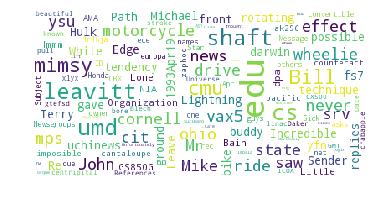

In [31]:
rand_idx=rd.randrange(0, len(texts))
wordcloud = WordCloud(max_font_size=40,background_color="white").generate(texts[rand_idx][0])

plt.imshow(wordcloud)
plt.axis("off")

# Step3: Train a classification model

### Define the model

In [32]:
def build_model(class_num=news20.CLASS_NUM,
                embedding_dim=embedding_dim,
                sequence_len=sequence_len):
    print "building model with embedding_dim = %s, sequence_len=%s"%(embedding_dim,sequence_len)
    model = Sequential()
    model.add(Reshape([embedding_dim, 1, sequence_len]))
    model.add(SpatialConvolution(embedding_dim, 128, 5, 1).set_name('conv1'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(SpatialConvolution(128, 128, 5, 1).set_name('conv2'))
    model.add(ReLU())
    model.add(SpatialMaxPooling(5, 1, 5, 1))
    model.add(Reshape([128]))
    model.add(Linear(128, 100).set_name('fc1'))
    model.add(Linear(100, class_num).set_name('fc2'))
    model.add(LogSoftMax())
    return model

model = build_model()

building model with embedding_dim = 50, sequence_len=50
creating: createSequential
creating: createReshape
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createSpatialConvolution
creating: createReLU
creating: createSpatialMaxPooling
creating: createReshape
creating: createLinear
creating: createLinear
creating: createLogSoftMax


### Train the model

In [33]:
print 'Start to train the model'
sample_rdd = prepare_samples(data_rdd, sequence_len, embedding_dim)
#split train val sets
train_rdd, val_rdd = sample_rdd.randomSplit([training_split, 1-training_split])

from nn.criterion import *
#configure optimizer
optimizer,train_summary1,val_summary1 = create_optimizer(model,'adagrad-'+ dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
trained_model = optimizer.optimize()
print "Optimization Done."

Start to train the model
preparing samples with embedding_dim = 50, sequence_len=50
Generated Samples
optimize summary will be write to : /tmp/bigdl_summaries/adagrad-20170327-063519
creating: createClassNLLCriterion
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
Optimization Done.


# Step 4: Evaluate the model output

### Loss curve

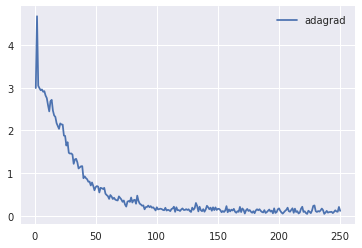

In [34]:
loss_adagrad = np.array(train_summary1.read_scalar("Loss"))
# each event data has 3-dimension value, in the form of (iteration_count, value, timestamp)
plt.plot(loss_adagrad[:,0],loss_adagrad[:,1],label='adagrad')
plt.legend()

### Confusion Matrix

done


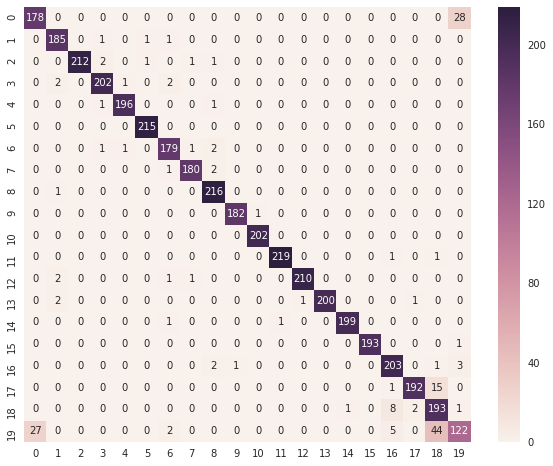

In [35]:
predictions = trained_model.predict(val_rdd)

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l[0] - 1

y_pred = np.array([ map_predict_label(s.label) for s in predictions.collect()])

y_true = np.array([map_groundtruth_label(s.label) for s in val_rdd.collect()])

cm = confusion_matrix(y_true, y_pred)
cm.shape

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d')
print("done")